In [41]:
#3Dtrackplot environment Python 3.9.15
import mpl_toolkits
from mpl_toolkits import mplot3d
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math as mt
import datetime
from datetime import datetime, timedelta, time

from mpl_toolkits.mplot3d import axes3d

import os

import statistics
import seaborn as sns


import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [34]:
#spreadsheet with the coordinates
data=pd.read_csv('/Users/secchim/Downloads/coordinates.csv', header=0)

#spreadsheet with the summary of the mice
mice=pd.read_csv('/Users/secchim/Downloads/summary.csv', header=0)

In [35]:
# Selecting the hoxb5 het genotype
#print(len(data))
data=data[data['Hoxb5_status_corrected']=='Hoxb5_het']
print(len(data))

2262


In [36]:
#Creating a unique Track ID per cell
#the + only work with strings
data['Track_ID']=((data['Experiment']).astype(str)+'_'+(data['Cage']).astype(str)+'_'+(data['Mouse']).astype(str)+'_'+(data['Position']).astype(str)+(data['Track_ID_IMARIS']).astype(str))
print(data['Track_ID'])

534      29_77579_LL_51000000000
535      29_77579_LL_51000000000
536      29_77579_LL_51000000000
537      29_77579_LL_51000000000
538      29_77579_LL_51000000000
                  ...           
3435    33_80542_LL_171000000042
3436    33_80542_LL_171000000042
3437    33_80542_LL_171000000042
3438    33_80542_LL_171000000042
3439    33_80542_LL_171000000042
Name: Track_ID, Length: 2262, dtype: object


In [37]:
#NORMALIZING POSITIONS TO THE FIRST COORDINATES

data['corrected_x_2']=data['x']
data['corrected_y_2']=data['y']
data['corrected_z_2']=data['z']
data['norm_x']=0
data['norm_y']=0
data['norm_z']=0
grouped=data.groupby(['Track_ID'])

dflist=[]
# print(grouped)
for i, newdf in grouped:
    newdf2=newdf[newdf['Timeframe_Time'] == (newdf['Timeframe_Time']).min()]#or '0'?
    norm_x=newdf2['x'].values
    norm_y=newdf2['y'].values
    norm_z=newdf2['z'].values

    newdf['norm_x']=[norm_x[0]]*len(newdf)#you could create pd.Series
    # print(newdf['norm_x'])
    newdf['corrected_x_2']=(newdf['x']-newdf['norm_x'])
    # print(newdf['corrected_x_2'])
    newdf['norm_y']=[norm_y[0]]*len(newdf)#you could create pd.Series
    newdf['corrected_y_2']=(newdf['y']-newdf['norm_y'])
    newdf['norm_z']=[norm_z[0]]*len(newdf)#you could create pd.Series
    newdf['corrected_z_2']=(newdf['z']-newdf['norm_z'])
    dflist.append(newdf)
data=pd.concat(dflist)
print(data)

      Experiment   Cage Mouse Sex  Age_weeks Hoxb5_status_corrected  \
1147          27  69154     L   M         22              Hoxb5_het   
1148          27  69154     L   M         22              Hoxb5_het   
1149          27  69154     L   M         22              Hoxb5_het   
1150          27  69154     L   M         22              Hoxb5_het   
1151          27  69154     L   M         22              Hoxb5_het   
...          ...    ...   ...  ..        ...                    ...   
3291          33  80542     R   M         11              Hoxb5_het   
3292          33  80542     R   M         11              Hoxb5_het   
3293          33  80542     R   M         11              Hoxb5_het   
3294          33  80542     R   M         11              Hoxb5_het   
3295          33  80542     R   M         11              Hoxb5_het   

     InVivoStaining Treatment  Position  Track_ID_IMARIS  ...        y  \
1147          FALSE        WT         7       1000000000  ...  182.025   

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/3880231449.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


In [38]:
#Add coordinates of the next frame to calculate distances
data['Final_Cell_ID']=data['Track_ID']

grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    newdf=newdf.sort_values(by=['Timeframe_Time'])
    print(newdf['Timeframe_Time'])
    dflist.append(newdf)
data=pd.concat(dflist)   

#shift takes the next row(?) and puts it in the current row
data["corrected_x_2_next"] = data["corrected_x_2"].shift(-1)
data["corrected_y_2_next"] = data["corrected_y_2"].shift(-1)
data["corrected_z_2_next"] = data["corrected_z_2"].shift(-1)
print(data["corrected_x_2_next"], data ["corrected_x_2"])

#annotate the last timeframe 
data["Last_timepoint"]=True
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    if newdf.shape[0]>=2:
        for b, r in newdf.iterrows():
            if (newdf.loc[b, "Timeframe_Time"])== (newdf['Timeframe_Time'].max()):
                newdf.loc[b, "Last_timepoint"]=True
            else:
                newdf.loc[b, "Last_timepoint"]=False
    dflist.append(newdf)
data=pd.concat(dflist)              
# print(data)

import math

# calculate distance between timeframes
data['distance']= None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    if newdf.shape[0]>=2:
        for b, r in newdf.iterrows():
            if (newdf.loc[b, 'Last_timepoint'])== False: 
                # print(b, newdf.loc[b, "Timeframe_Time"], newdf.loc[b,'Final_Cell_ID'], newdf.loc[b,'Metadata_Timepoint'], newdf.shape[0]-1)
                # try:
                newdf.loc[b, "distance"]=(math.sqrt((newdf.loc[b, "corrected_x_2"]-newdf.loc[b, "corrected_x_2_next"])**2+(newdf.loc[b, "corrected_y_2"]-newdf.loc[b, "corrected_y_2_next"])**2+(newdf.loc[b, "corrected_z_2"]-newdf.loc[b, "corrected_z_2_next"])**2))
                    # newdf["distance"]=(math.sqrt((newdf["corrected_x_2"][r]-newdf["corrected_x_2"][r+1])**2+(newdf["corrected_y_2"][r]-newdf["corrected_y_2"][r+1])**2+(newdf["corrected_z_2"][r]-newdf["corrected_z_2"][r+1])**2))
                # except:
                    # print(i, b, "error")
                    # newdf.loc[b, "distance"]='NaN'
                    # pass
        # print(newdf["distance"])
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['distance'])
#.sort_values(by=['Timeframe_Time']).reset_index()

#Calculate track length
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    newdf.dropna()
    newdf['track_length']=newdf['distance'].sum()
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['track_length'])   

#calculate displacement for every timepoint
data['displacement']=None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    stored_X0=newdf['corrected_x_2'][newdf['Timeframe_Time'] == (newdf['Timeframe_Time']).min()]
    stored_Y0=newdf['corrected_y_2'][newdf['Timeframe_Time'] == (newdf['Timeframe_Time']).min()]
    stored_Z0=newdf['corrected_z_2'][newdf['Timeframe_Time'] == (newdf['Timeframe_Time']).min()]
    for b, r in newdf.iterrows():
        newdf.loc[b, "displacement"]=math.sqrt((newdf["corrected_x_2"][b]-stored_X0)**2+(newdf["corrected_y_2"][b]-stored_Y0)**2+(newdf["corrected_z_2"][b]-stored_Z0)**2)
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['displacement'])


#maximum displacement
data['max_displacement']=None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    newdf['max_displacement']=newdf['displacement'].max()
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['max_displacement'])


#mean speed in um/sec
#potentially wrong
data['mean_speed']=None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    if newdf.shape[0]>=2:
        mean_speed=newdf['track_length']/(newdf['Timeframe_Time'].max()*180)#*180 because imaged every 3min
        newdf['mean_speed']=mean_speed
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['mean_speed'])

data["Timeframe_Time_next"] = data["Timeframe_Time"].shift(-1)

#frame speed
data=data.drop_duplicates() #why do I have duplicates?
data['frame_speed']=None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    if newdf.shape[0]>=2:
        for b, r in newdf.iterrows():
            if (newdf.loc[b, 'Last_timepoint'])== False: 
            #if newdf.loc[b,'displacement']>0 and newdf.loc[b+1, 'displacement']>0:
            # try:
                newdf.loc[b, "frame_speed"]=abs(newdf.loc[b,'distance']/180)#because imaged every 3min
            # except:
                # newdf.loc[b, "frame_speed"]='NaN'
            # print(b, newdf["frame_speed"])
                # pass
            # else:
                # print(b, 'error')
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['frame_speed'])

#linearity coefficient

data['linearity_coefficient']=None
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    newdf['linearity_coefficient']=newdf['max_displacement']/newdf['track_length']
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['linearity_coefficient'])

#arrest coefficient
#speed<2/60um/sec

# data=data.dropna(axis=0)
#First classifying timeframes as arrested or not
data['arrested']=False
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    for b, r in newdf.iterrows():
        # print((newdf.loc[b,'mean_speed']),2/60, b)
        # print(newdf.loc[b])
        if (newdf.loc[b,'frame_speed'])!=None and (newdf.loc[b,'frame_speed'])<(2/60): #different from NaN
            newdf.loc[b,'arrested']=True
        else :
            newdf.loc[b,'arrested']=False
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['arrested'])

datax=data.drop_duplicates()

data['arrest_coefficient']=False
data=data.drop_duplicates()
grouped=data.groupby(['Final_Cell_ID'])
dflist=[]
for i, newdf in grouped:
    newdf2=newdf[newdf['arrested']==True]
    newdf3=newdf[newdf['arrested']==False]
    # print(newdf2['arrested'].shape[0],newdf3['arrested'].shape[0])
    if ((newdf2.shape[0])+(newdf3.shape[0]))>1:
        newdf['arrest_coefficient']=(newdf2.shape[0])/((newdf2.shape[0])+(newdf3.shape[0]))
    dflist.append(newdf)
data=pd.concat(dflist)
print(data['arrest_coefficient'])

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/559063576.py:6: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/559063576.py:22: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


1147     1
1148     2
1149     3
1150     4
1151     5
1152     6
1153     7
1154     8
1155     9
1156    10
1157    11
1158    12
1159    13
1160    14
1161    15
1162    16
1163    17
1164    18
1165    19
1166    20
1167    21
Name: Timeframe_Time, dtype: int64
1168     1
1169     2
1170     3
1171     4
1172     5
1173     6
1174     7
1175     8
1176     9
1177    10
1178    11
1179    12
1180    13
1181    14
1182    15
1183    16
1184    17
1185    18
1186    19
Name: Timeframe_Time, dtype: int64
1187     1
1188     2
1189     3
1190     4
1191     5
1192     6
1193     7
1194     8
1195     9
1196    10
1197    11
1198    12
1199    13
1200    14
1201    15
1202    16
1203    17
1204    18
1205    19
Name: Timeframe_Time, dtype: int64
1206     1
1207     2
1208     3
1209     4
1210     5
1211     6
1212     7
1213     8
1214     9
1215    10
1216    11
1217    12
1218    13
1219    14
1220    15
1221    16
1222    17
1223    18
1224    19
1225    20
1226    21
Name: Timeframe

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/559063576.py:39: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


1147    2.085496
1148    5.756481
1149    0.955722
1150    1.587324
1151    8.033767
          ...   
3291    0.743138
3292         0.0
3293         0.0
3294    0.663942
3295        None
Name: distance, Length: 2262, dtype: object
1147    58.362802
1148    58.362802
1149    58.362802
1150    58.362802
1151    58.362802
          ...    
3291    43.215736
3292    43.215736
3293    43.215736
3294    43.215736
3295    43.215736
Name: track_length, Length: 2262, dtype: float64


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/559063576.py:60: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/559063576.py:71: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


1147          0.0
1148     2.085496
1149     3.885445
1150     4.341474
1151     5.431774
          ...    
3291     26.21788
3292    25.544124
3293    25.544124
3294    25.544124
3295    26.174645
Name: displacement, Length: 2262, dtype: object
1147    13.152716
1148    13.152716
1149    13.152716
1150    13.152716
1151    13.152716
          ...    
3291    26.217880
3292    26.217880
3293    26.217880
3294    26.217880
3295    26.217880
Name: max_displacement, Length: 2262, dtype: float64
1147    0.015440
1148    0.015440
1149    0.015440
1150    0.015440
1151    0.015440
          ...   
3291    0.011433
3292    0.011433
3293    0.011433
3294    0.011433
3295    0.011433
Name: mean_speed, Length: 2262, dtype: float64


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/559063576.py:86: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/559063576.py:98: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/559063576.py:113: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


1147    0.011586
1148     0.03198
1149     0.00531
1150    0.008818
1151    0.044632
          ...   
3291    0.004129
3292         0.0
3293         0.0
3294    0.003689
3295        None
Name: frame_speed, Length: 2262, dtype: object
1147    0.225361
1148    0.225361
1149    0.225361
1150    0.225361
1151    0.225361
          ...   
3291    0.606674
3292    0.606674
3293    0.606674
3294    0.606674
3295    0.606674
Name: linearity_coefficient, Length: 2262, dtype: float64


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/559063576.py:135: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/559063576.py:149: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


1147     True
1148     True
1149     True
1150     True
1151    False
        ...  
3291     True
3292     True
3293     True
3294     True
3295    False
Name: arrested, Length: 2262, dtype: bool
1147    0.761905
1148    0.761905
1149    0.761905
1150    0.761905
1151    0.761905
          ...   
3291    0.937500
3292    0.937500
3293    0.937500
3294    0.937500
3295    0.937500
Name: arrest_coefficient, Length: 2262, dtype: float64


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/559063576.py:167: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


In [39]:
number_of_cells=data['Final_Cell_ID'].unique()
print(len(number_of_cells))

#exporting data

data.to_csv('/Users/secchim/Downloads/track_Sara.csv')

79


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/4089977288.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/4089977288.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


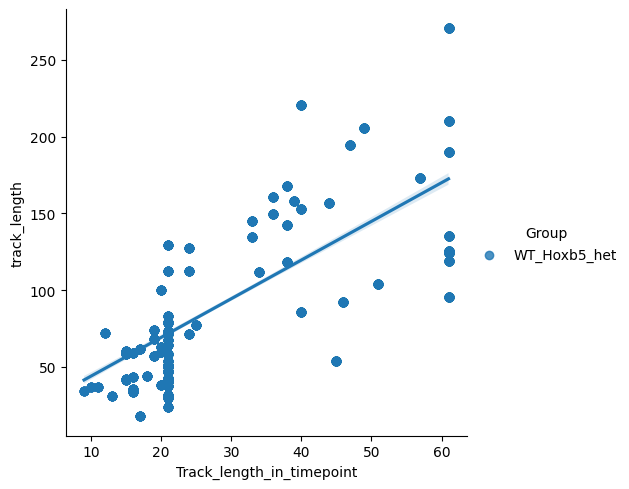

In [40]:
#PRINT TRACK LENGTH AS A FUNCTION OF TIME LENGTH 

datax=data[data['track_length']!=0]
datab=datax[['Final_Cell_ID', 'Timeframe_Time', 'track_length','Treatment', 'Hoxb5_status_corrected']]
datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']
datab.dropna()

df_list =[]
grouped=datab.groupby(['Final_Cell_ID'])
for i, newdf in grouped:
    newdf['Track_length_in_timepoint']=newdf.shape[0]
    df_list.append(newdf)
datab=pd.concat(df_list)

##PLOTTING TREATED MICE
# figure size in inches #THE SMALLER THE FIGURES ARE THE BIGGER THE TEXT
# fig, ax = plt.subplots(figsize=(12,9))#6,4.5
# g=sns.scatterplot(x="Track_length_in_timepoint", y="track_length", data=datab )
# sns.scatterplot(x="Track_length_in_timepoint", y="track_length", data=datab)

# https://seaborn.pydata.org/generated/seaborn.lineplot.html
sns.lmplot(data=datab, x='Track_length_in_timepoint', y='track_length', hue='Group', col=None, row=None, palette=None, col_wrap=None, height=5, aspect=1, markers='o', sharex=None, sharey=None, 
            hue_order=None, col_order=None, row_order=None, legend=True, legend_out=None, x_estimator=None, x_bins=None, x_ci='ci', scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None, 
            seed=None, order=1, logistic=False, lowess=False, robust=False, logx=False, x_partial=None, y_partial=None, truncate=True, x_jitter=None, y_jitter=None, scatter_kws=None, line_kws=None, 
            facet_kws=None)
# g.set(ylim=(0, 200))

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/2111980702.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['distance'] = datab['distance'].astype(float)
/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='Treatment', ylabel='distance'>

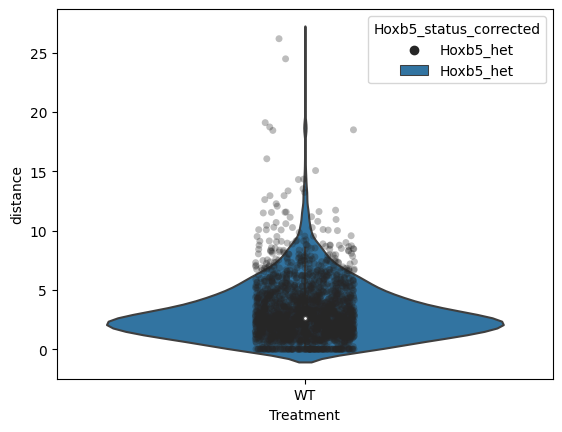

In [46]:
##DISTANCE VIOLIN PLOT
datab=datax[['Final_Cell_ID', 'Timeframe_Time', 'distance','Treatment', 'Hoxb5_status_corrected']]
datab['distance'] = datab['distance'].astype(float)
sns.stripplot( x=("Treatment"),hue='Hoxb5_status_corrected', y="distance", data=datab, dodge=True, color='black', alpha=0.3)# order =['homeostasis','plt_depletion','24h_depletion']
sns.violinplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="distance", data=datab)# order =['homeostasis','plt_depletion','24h_depletion']

# model = ols('distance ~ C(Hoxb5_status_corrected) + C(Treatment) + C(Hoxb5_status_corrected):C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/3321436621.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['frame_speed'] = datab['frame_speed'].astype(float)
/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='Treatment', ylabel='frame_speed'>

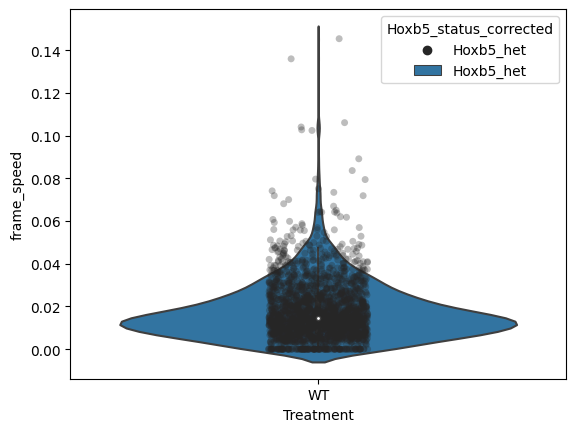

In [50]:
###FRAME SPEED VIOLIN PLOT
datab=datax[['Final_Cell_ID', 'Timeframe_Time', 'frame_speed','Treatment', 'Hoxb5_status_corrected']]
# dx=datax[datax['frame_speed']!=0]
datab['frame_speed'] = datab['frame_speed'].astype(float)
dx.dropna()
sns.stripplot( x=("Treatment"),hue='Hoxb5_status_corrected', y="frame_speed", data=datab, dodge=True, color='black', alpha=0.3)#, order =['homeostasis','plt_depletion','24h_depletion']
sns.violinplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="frame_speed", data=datab)
# model = ols('frame_speed ~ C(Hoxb5_status_corrected) + C(Treatment) + C(Hoxb5_status_corrected):C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)

/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='Treatment', ylabel='linearity_coefficient'>

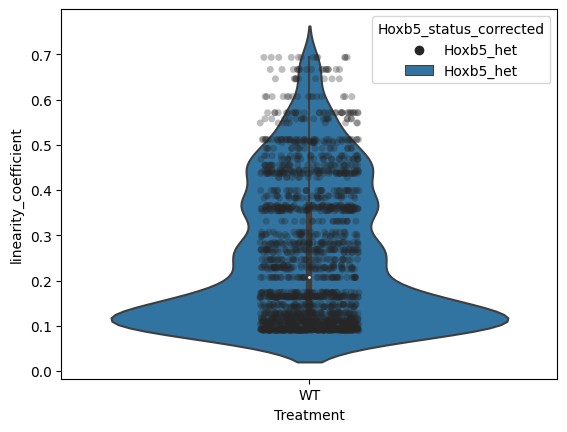

In [53]:
##LINEARITY COEFFICIENT VIOLIN PLOT
dx=datax[['Final_Cell_ID', 'Treatment', 'Hoxb5_status_corrected', 'linearity_coefficient','max_displacement']]
dx.dropna()

#THIS LINE EXCLUDES THE CELLS THAT ARE NOT REALLY MOVING
dx=dx[dx['max_displacement']>10]

dx.drop_duplicates()
# sns.stripplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="linearity_coefficient", data=dx, dodge=True, order =['homeostasis','plt_depletion','24h_depletion'])
sns.stripplot( x=("Treatment"),hue='Hoxb5_status_corrected', y="linearity_coefficient", data=dx, dodge=True, color='black', alpha=0.3)# order =['homeostasis','plt_depletion','24h_depletion']
sns.violinplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="linearity_coefficient", data=dx)

# model = ols('linearity_coefficient ~ C(Hoxb5_status_corrected) + C(Treatment) + C(Hoxb5_status_corrected):C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)

In [58]:
#importing Marine's data

manual=pd.read_csv('/Users/secchim/Downloads/manual_tracks230711.csv', header = 0)

manual['FileID']=manual['file'].astype(str).str.upper()
for b, r in manual.iterrows():
            (manual.loc[b, "FileID"])=manual.loc[b,'FileID'][0:19]
# print(manual['FileID'])

FileID_list=manual['FileID'].unique()
# print(FileID_list)

df_list =[]
grouped=manual.groupby(['Final_Cell_ID'])
for i, newdf in grouped:
    if len(newdf.index) >=11:
        df_list.append(newdf)
manual11=pd.concat(df_list)
manu=manual11
manu=manu.drop_duplicates()

dataMS=pd.concat([data, manu], axis=0, ignore_index=True)
print(len(manu))
print(len(dataMS))

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/3374974447.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


3460
5722


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/265379704.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']
/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/265379704.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, newdf in grouped:


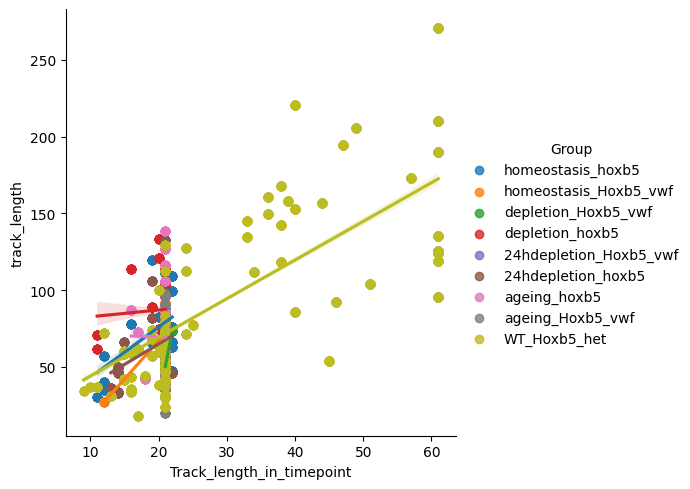

In [59]:
#PRINT TRACK LENGTH AS A FUNCTION OF TIME LENGTH 

datax=dataMS[dataMS['track_length']!=0]
datab=datax[['Final_Cell_ID', 'Timeframe_Time', 'track_length','Treatment', 'Hoxb5_status_corrected']]
datab['Group']=datab['Treatment']+'_'+datab['Hoxb5_status_corrected']
datab.dropna()

df_list =[]
grouped=datab.groupby(['Final_Cell_ID'])
for i, newdf in grouped:
    newdf['Track_length_in_timepoint']=newdf.shape[0]
    df_list.append(newdf)
datab=pd.concat(df_list)

##PLOTTING TREATED MICE
# figure size in inches #THE SMALLER THE FIGURES ARE THE BIGGER THE TEXT
# fig, ax = plt.subplots(figsize=(12,9))#6,4.5
# g=sns.scatterplot(x="Track_length_in_timepoint", y="track_length", data=datab )
# sns.scatterplot(x="Track_length_in_timepoint", y="track_length", data=datab)

# https://seaborn.pydata.org/generated/seaborn.lineplot.html
sns.lmplot(data=datab, x='Track_length_in_timepoint', y='track_length', hue='Group', col=None, row=None, palette=None, col_wrap=None, height=5, aspect=1, markers='o', sharex=None, sharey=None, 
            hue_order=None, col_order=None, row_order=None, legend=True, legend_out=None, x_estimator=None, x_bins=None, x_ci='ci', scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None, 
            seed=None, order=1, logistic=False, lowess=False, robust=False, logx=False, x_partial=None, y_partial=None, truncate=True, x_jitter=None, y_jitter=None, scatter_kws=None, line_kws=None, 
            facet_kws=None)
# g.set(ylim=(0, 200))

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/2736826155.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['distance'] = datab['distance'].astype(float)
/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='Treatment', ylabel='distance'>

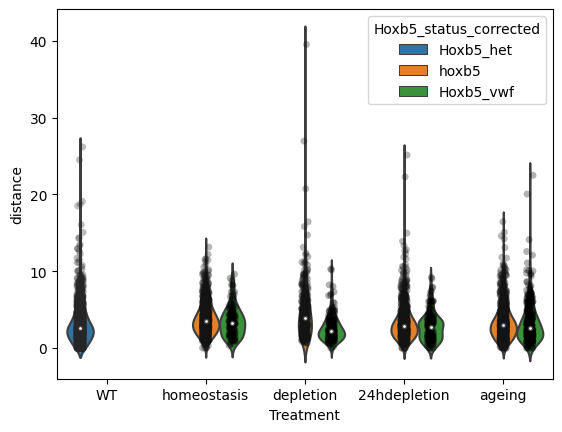

In [67]:
##DISTANCE VIOLIN PLOT
datax=datax[datax['Timeframe_Time']<=21]

datab=datax[['Final_Cell_ID', 'Timeframe_Time', 'distance','Treatment', 'Hoxb5_status_corrected']]
datab['distance'] = datab['distance'].astype(float)
sns.stripplot( x=("Treatment"),hue='Hoxb5_status_corrected', y="distance", data=datab, dodge=True, color='black', alpha=0.3, legend=None)# order =['homeostasis','plt_depletion','24h_depletion']
sns.violinplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="distance", data=datab)# order =['homeostasis','plt_depletion','24h_depletion']

# model = ols('distance ~ C(Hoxb5_status_corrected) + C(Treatment) + C(Hoxb5_status_corrected):C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)

0        1
1        2
2        3
3        4
4        5
        ..
5717    17
5718    18
5719    19
5720    20
5721    21
Name: Timeframe_Time, Length: 4938, dtype: int64


/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/4029762427.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['track_length'] = datab['track_length'].astype(float)
/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='Treatment', ylabel='track_length'>

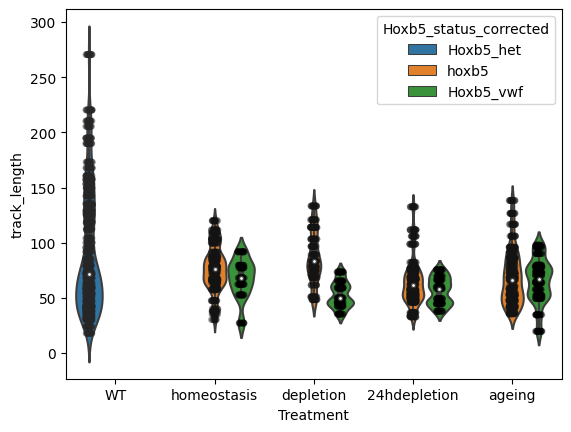

In [69]:
##DISTANCE VIOLIN PLOT
datax=datax[datax['Timeframe_Time']<=21]
print(datax['Timeframe_Time'])

datab=datax[['Final_Cell_ID', 'Timeframe_Time', 'track_length','Treatment', 'Hoxb5_status_corrected']]
datab['track_length'] = datab['track_length'].astype(float)
sns.stripplot( x=("Treatment"),hue='Hoxb5_status_corrected', y="track_length", data=datab, dodge=True, color='black', alpha=0.3, legend=None)# order =['homeostasis','plt_depletion','24h_depletion']
sns.violinplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="track_length", data=datab)# order =['homeostasis','plt_depletion','24h_depletion']

# model = ols('distance ~ C(Hoxb5_status_corrected) + C(Treatment) + C(Hoxb5_status_corrected):C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)

/var/folders/m1/973p2py16d5bwyw1r5whmn0hh54wfr/T/ipykernel_54100/72703305.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datab['mean_speed'] = datab['mean_speed'].astype(float)
/opt/anaconda3/envs/3Dtrackplot/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='Treatment', ylabel='mean_speed'>

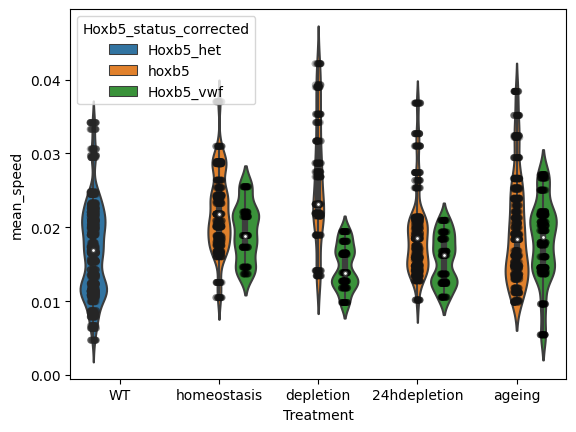

In [66]:
###Mean FRAME SPEED VIOLIN PLOT
datab=datax[['Final_Cell_ID', 'Timeframe_Time', 'mean_speed','Treatment', 'Hoxb5_status_corrected']]
# dx=datax[datax['frame_speed']!=0]
datab['mean_speed'] = datab['mean_speed'].astype(float)
dx.dropna()
sns.stripplot( x=("Treatment"),hue='Hoxb5_status_corrected', y="mean_speed", data=datab, dodge=True, color='black', alpha=0.3, legend=None)#, order =['homeostasis','plt_depletion','24h_depletion']
sns.violinplot(x=("Treatment"),hue='Hoxb5_status_corrected', y="mean_speed", data=datab)
# model = ols('frame_speed ~ C(Hoxb5_status_corrected) + C(Treatment) + C(Hoxb5_status_corrected):C(Treatment)', data=dx).fit()
# sm.stats.anova_lm(model, typ=2)

New size: [12, 9]


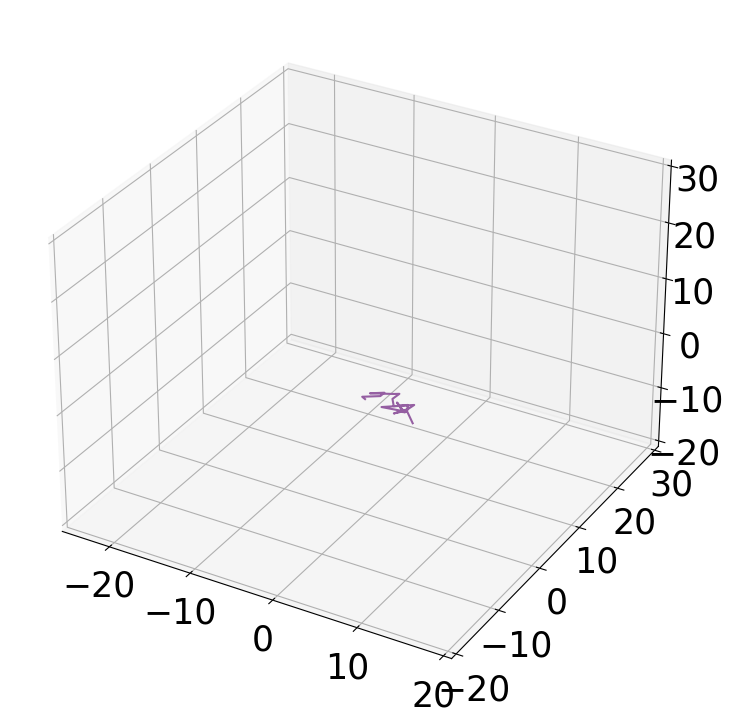

In [84]:
### homeostasis plot, separating Hoxb5+ and Hoxb5+Vwf+ FOR POSTER FIGURE NO LEGEND

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

my_list_hoxb5vwf = [1.1]

for a in my_list_hoxb5vwf:
    data= dataMS[(dataMS['Final_Cell_ID'] == a)]
    X1= data['corrected_x_2']
    Y1= data['corrected_y_2']
    Z1= data['corrected_z_2']
    r= random.random()
    b= random.random()
    g= random.random()
    ax.plot(X1, Y1, Z1, c=(r,g,b))
    
    ax.set_xlim(-25, 20)
    ax.set_ylim(-20, 30)
    ax.set_zlim(-20, 30)


    # Set figure width to 12 and height to 9
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    plt.rcParams['axes.labelsize']=15
    print ("New size:", fig_size)
